# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage,cophenet,dendrogram,fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
mrci=pd.read_csv('../data/MRCI_clus_2310.csv')
scaler = StandardScaler()
mrci_standardized = scaler.fit_transform(mrci)
mrci_standardized_df = pd.DataFrame(mrci_standardized, columns=mrci.columns)
mrci_standardized_df.head()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
0,-0.100214,-1.637257,-1.969576,0.157315,1.135143
1,0.737952,0.801589,0.147183,0.391960,1.402825
2,0.002207,1.067360,0.040668,-1.487806,1.402825
3,1.205524,-1.629440,-1.947411,0.639641,-0.203263
4,0.260980,0.629619,0.749333,-0.125128,1.402825


I will consider 4 **linkage methods** for each of Euclidean distance and Manhattan distance: 

1. Single linkage
2. Complete linkage
3. Average linkage
4. Ward linkage (not compatible with the Manhattan distance)

**The cophenetic correlation coefficient** is a measure used to validate the quality of a hierarchical clustering. It evaluates how faithfully the dendrogram (a tree-like diagram produced by hierarchical clustering) preserves the pairwise distances between the original unclustered data points.

For every pair of data points:

1. In the original dataset, I measure their actual pairwise distance.
2. In the dendrogram, I measure the height (or level) at which the two points are first joined together in a single cluster.

The cophenetic correlation coefficient is the Pearson correlation between these two sets of distances. A high cophenetic correlation indicates that the dendrogram well represents the original distances among data points.

I will perform hierarchical clustering using different linkage methods and compute the cophenetic correlation coefficient for each one. The linkage method that gives the highest cophenetic correlation will be considered the most appropriate for clustering the given data.

In [3]:
linkage_methods = ["single", "complete", "average", "ward"]
distance_metrics = ["euclidean", "cityblock"]  
results = {}
for method in linkage_methods:
    for metric in distance_metrics:
        if method == "ward" and metric == "cityblock":
            continue
        Z = linkage(mrci_standardized, method=method, metric=metric)
        coph_corr, _ = cophenet(Z, pdist(mrci_standardized, metric=metric))
        results[(method, metric)] = coph_corr
results

{('single', 'euclidean'): 0.5813132120634711,
 ('single', 'cityblock'): 0.5622789694333536,
 ('complete', 'euclidean'): 0.5380227876741392,
 ('complete', 'cityblock'): 0.6408361438880572,
 ('average', 'euclidean'): 0.7665973764988033,
 ('average', 'cityblock'): 0.7091822595538302,
 ('ward', 'euclidean'): 0.5723214644160851}

**For Euclidean distance:**

The highest cophenetic correlation coefficient is 0.7666, which corresponds to the combination of the **Average linkage** method and the Euclidean distance metric.Therefore, Average linkage is the most appropriate for clustering the given dataset.

**For Manhattan distance:**

The highest cophenetic correlation coefficient is 0.7092, which corresponds to the combination of the **Average linkage** method and the Manhattan distance metric.Therefore, Average linkage is the most appropriate for clustering the given dataset.

In [4]:
max_clusters = 10
cluster_range = range(2, max_clusters + 1)
sil_scores = {}
specified_combinations = [('average', 'euclidean'), ('average', 'cityblock')]
for method, metric in specified_combinations:
    Z = linkage(mrci_standardized, method=method, metric=metric)
    method_metric_scores = []
    for k in cluster_range:
        labels = fcluster(Z, k, criterion='maxclust')
        score = silhouette_score(mrci_standardized, labels, metric=metric)
        method_metric_scores.append(score)
    sil_scores[(method, metric)] = method_metric_scores
optimal_clusters = {}
for key, scores in sil_scores.items():
    optimal_k = cluster_range[scores.index(max(scores))]
    optimal_clusters[key] = optimal_k
optimal_clusters

{('average', 'euclidean'): 2, ('average', 'cityblock'): 2}

Above are the optimal or near-optimal **numbers of clusters** for each combination based on the silhouette scores: **2**

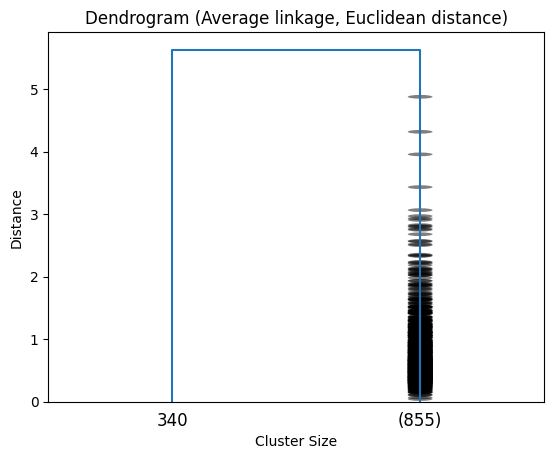

In [5]:
Z_euclidean = linkage(mrci_standardized, method='average', metric='euclidean')
dendrogram(Z_euclidean, truncate_mode='lastp', p=2, show_contracted=True)
plt.title("Dendrogram (Average linkage, Euclidean distance)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

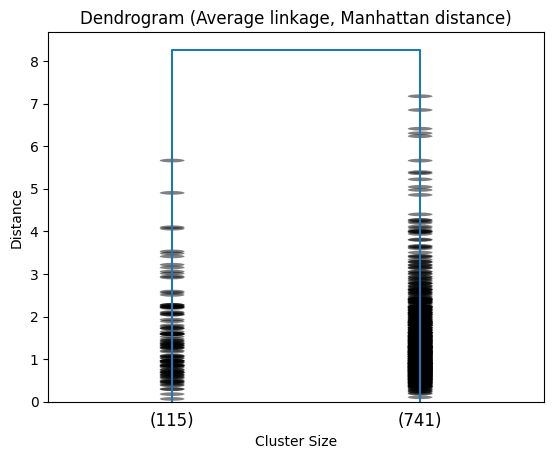

In [6]:
Z_manhattan = linkage(mrci_standardized, method='average', metric='cityblock') 
dendrogram(Z_manhattan, truncate_mode='lastp', p=2, show_contracted=True) 
plt.title("Dendrogram (Average linkage, Manhattan distance)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

In [7]:
cluster_properties = {}
for key, k in optimal_clusters.items():
    method, metric = key
    Z = linkage(mrci_standardized, method=method, metric=metric)
    labels = fcluster(Z, k, criterion='maxclust')
    mrci['Cluster'] = labels
    cluster_summary = mrci.groupby('Cluster').mean()
    cluster_properties[key] = cluster_summary
cluster_properties

{('average',
  'euclidean'):          ADM_RATE      SAT_AVG    C150_4  UGDS_WOMEN    STUFACR
 Cluster                                                        
 1        0.736078  1163.395322  0.600377    0.576572  13.762573
 2        0.886500  1213.000000  0.787100    0.000000  11.000000,
 ('average',
  'cityblock'):          ADM_RATE      SAT_AVG    C150_4  UGDS_WOMEN    STUFACR
 Cluster                                                        
 1        0.401553  1399.243478  0.857648    0.540623  11.408696
 2        0.788198  1126.859649  0.560701    0.581373  14.124157}

**Average linkage method and the Euclidean distance with 2 clusters:**

1. Cluster 1:

  Admission Rate: 0.7361

  Average SAT Score: 1163.40

  Completion Rate: 0.6004

  Percentage of Women Students: 57.66%

  Student-to-Faculty Ratio: 13.76


2. Cluster 2:

  Admission Rate: 0.8865

  Average SAT Score: 1213.0

  Completion Rate: 0.7871

  Percentage of Women Students: 0%

  Student-to-Faculty Ratio: 11.0

**Average linkage method and the Manhattan distance with 2 clusters:**

1. Cluster 1:

  Admission Rate: 0.4016

  Average SAT Score: 1399.24

  Completion Rate: 0.8576

  Percentage of Women Students: 54.06%

  Student-to-Faculty Ratio: 11.41


2. Cluster 2:

  Admission Rate: 0.7882

  Average SAT Score: 1126.86

  Completion Rate: 0.5607

  Percentage of Women Students: 58.14%

  Student-to-Faculty Ratio: 14.12

For the **Euclidean distance metric**, Cluster 1 seems to represent colleges with a lower admission rate, slightly lower SAT scores, and a larger proportion of women students, while Cluster 2 represents colleges with an exceptionally low percentage of women students.

For the **Manhattan distance metric**, Cluster 1 captures colleges with a lower admission rate, higher SAT scores, higher completion rate, and a lower student-to-faculty ratio, while Cluster 2 seems to capture colleges with higher admission rates, lower SAT scores, lower completion rate, and a higher student-to-faculty ratio.

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.

In [85]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [86]:
df=pd.read_csv('../data/MRCI_regr_2310.csv')
df.head()

,ADM_RATE,SAT_AVG,UGDS,COSTT4_A,C150_4,UGDS_WOMEN,STUFACR,MD_EARN_WNE_1YR,STATE
0,0.7160,954.0,5098.0,21924.0,0.2807,0.5940,18.0,30999.0,Alabama
1,0.8854,1266.0,13284.0,26248.0,0.6245,0.6210,19.0,45270.0,Alabama
2,0.7367,1300.0,7358.0,24869.0,0.6072,0.4047,19.0,57386.0,Alabama
3,0.9799,955.0,3495.0,21938.0,0.2843,0.6495,13.0,27282.0,Alabama
4,0.7890,1244.0,30725.0,31050.0,0.7223,0.5615,19.0,44620.0,Alabama


In [87]:
X = df[["ADM_RATE", "SAT_AVG", "UGDS", "COSTT4_A", "C150_4", "UGDS_WOMEN", "STUFACR"]]
y = df["MD_EARN_WNE_1YR"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.92e-44
Time:                        23:14:19   Log-Likelihood:                -8989.4
No. Observations:                 851   AIC:                         1.799e+04
Df Residuals:                     843   BIC:                         1.803e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.44e+04   6241.833      3.908      0.000    1.21e+04    3.66e+04
ADM_RATE     190.1183   1945.929      0.098      0.922   -3629.316    4009.553
SAT_AVG       15.8144      5.303      2.982      0.003       5.405      26.224
UGDS           0.0837      0.055      1.521      0.129      -0.024       0.192
COSTT4_A       0.0490      0.030      1.654      0.098      -0.009       0.107
C150_4      1.204e+04   3852.555      3.125      0.002    4477.105    1.96e+04
UGDS_WOMEN -1.114e+04   2902.217     -3.837      0.000   -1.68e+04   -5438.779
STUFACR     -217.0074    121.077     -1.792      0.073    -454.656      20.641
==============================================================================
Omnibus:                      182.328   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              929.734
Skew:                           0.877   Prob(JB):                    1.29e-202
Kurtosis:                       7.811   Cond. No.                     8.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Fit Assessment:**

1. Goodness-of-fit

$R^2$ is the proportion of the variance in the dependent variable that is predictable from the independent variables. Our model has an $R^2$ of 0.229, which implies that only about 22.9% of the variation in MD_EARN_WNE_1YR (median earnings one year after graduation) is explained by our predictors. This suggests that a significant amount of variability in earnings is still unexplained by the model.

Adjusted $R^2$ is 0.223, which accounts for the number of predictors in the model and provides a more accurate measure of goodness-of-fit when multiple predictors are used. The fact that it's close to $R^2$ indicates that most of the predictors are contributing to the model's explanatory power.

2. Model Significance

The F-statistic tests the hypothesis that all regression coefficients are equal to zero, meaning that the model is not a good fit to the data. An F-statistic of 35.77 with a very low associated p-value (almost zero) suggests that the model is statistically significant and fits the data better than a model with no independent variables.

3. Coefficients

The coefficients represent the change in the dependent variable for a one-unit change in the predictor, while holding other predictors constant. For instance, for every one-point increase in SAT_AVG, the median earnings increase by $15.81, holding all else constant.

The p-values associated with each coefficient indicate their significance. Variables like SAT_AVG, C150_4, and UGDS_WOMEN are significant at the 0.01 level, implying strong evidence against the null hypothesis that these variables have no effect on earnings.

4. Residual Analysis

The Omnibus test checks the skewness and kurtosis of the residuals. A significant result suggests that residuals are not normally distributed. Our model's residuals appear not to be normally distributed given the low p-value.

The Durbin-Watson statistic detects the presence of autocorrelation in the residuals. A value between 1 and 2 typically suggests that there is no autocorrelation. Our value of 1.675 indicates no significant autocorrelation.

The Jarque-Bera (JB) test also checks for normality in the residuals. A large JB value indicates that errors are not normally distributed. Our model's residuals seem not to be normally distributed based on this test.

5. Model Issues

The condition number is large, suggesting potential multicollinearity or other numerical problems. As mentioned earlier, multicollinearity refers to a situation in which two or more predictors in the model are correlated. It can make coefficients unstable and hard to interpret.

**Then I will study the residuals:**

Text(0.5, 1.0, 'Fitted Values')

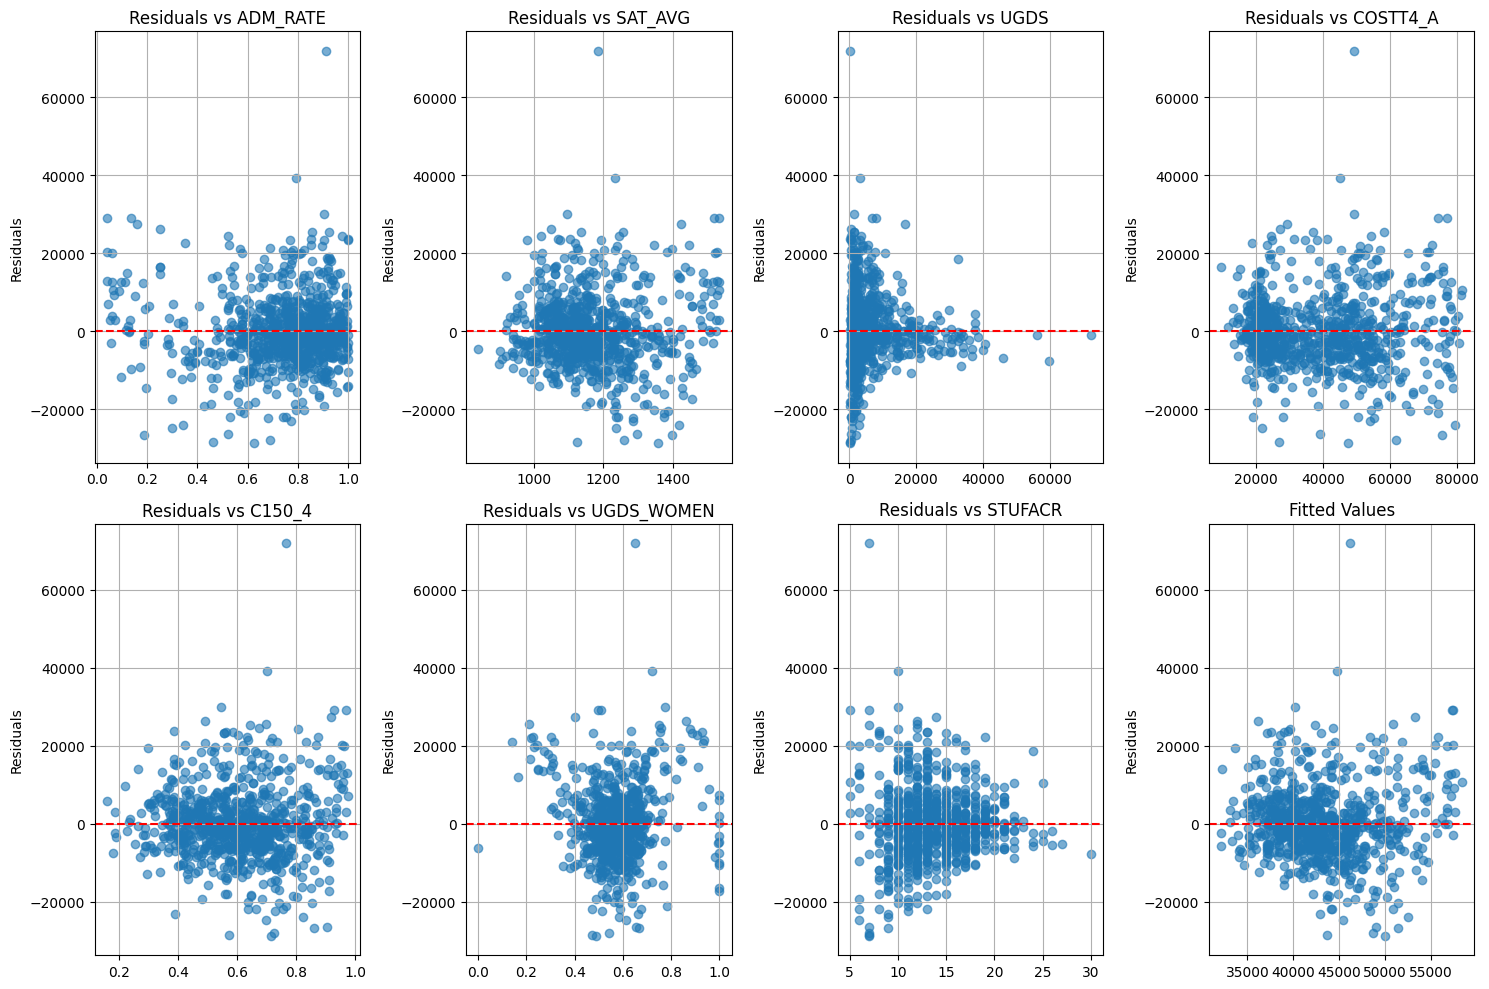

In [88]:
residuals = model.resid
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(15,10))

for i,cc in enumerate(X.columns[1:]):
    plt.subplot(2,4, i+1)
    plt.scatter(X[cc], residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.title(f"Residuals vs {cc}")

plt.subplot(248)
plt.scatter(model.fittedvalues, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout() 
plt.title('Fitted Values')

The residuals-vs-fitted values plot helps us identify non-linearity, unequal error variances, and outliers.

**Non-linearity:** The residuals should be scattered randomly around the horizontal axis. If we see a clear pattern (like a U-shape or a curve), it suggests that our model is not capturing the non-linear relationship in the data. From the plot, we can see that there isn't a distinct pattern, suggesting that non-linearity might not be a significant issue in this model.

**Unequal Variances (Heteroskedasticity):** The spread of residuals should be roughly the same across all values of the fitted values. If the spread increases or decreases, then the assumption of homoskedasticity is violated. The plot suggests that there might be some heteroskedasticity, as the spread of residuals seems to widen as the fitted values increase.

**Outliers:**  Points that stand far away from the zero line could be potential outliers. There appear to be a few potential outliers, but a more formal test (like Cook's distance) can give us a better idea.

Now let's see the differences in **beta coefficient** values, along with the **Cook's distance** plot.

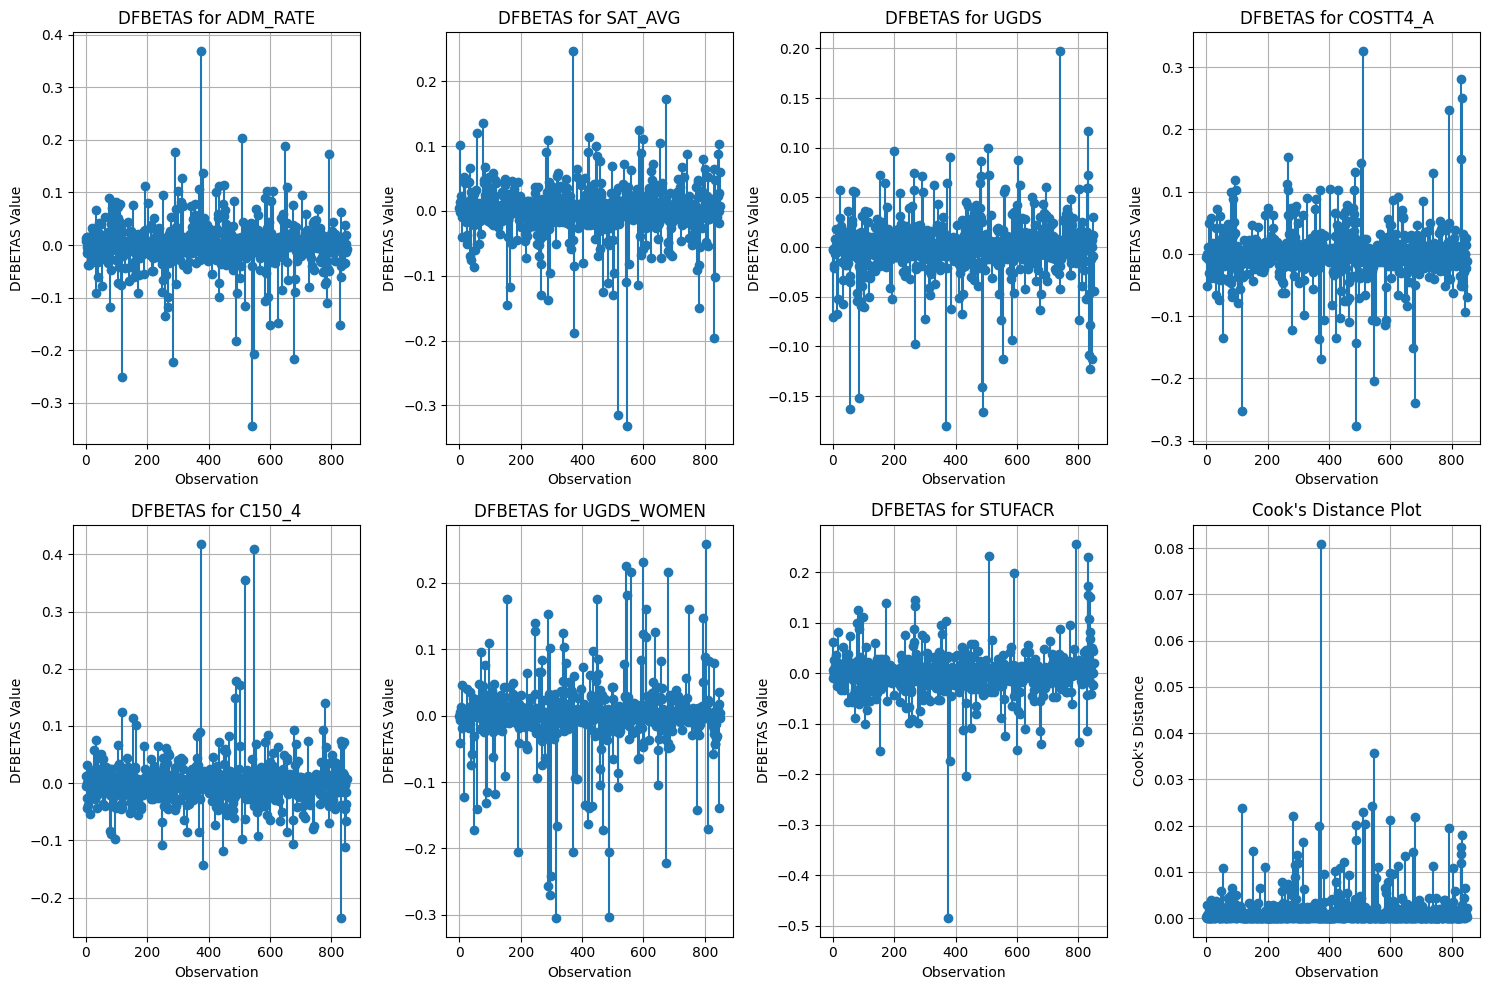

In [89]:
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(15,10))

for i,cc in enumerate(X.columns[1:]):
    plt.subplot(2,4, i+1)
    plt.stem(np.arange(len(influence.dfbetas)), influence.dfbetas[:,i+1], basefmt=" ")
    plt.title(f"DFBETAS for {cc}")
    plt.xlabel('Observation')
    plt.ylabel('DFBETAS Value')
    plt.grid(True)

plt.subplot(248)
plt.stem(cooks_distance, basefmt=" ")
plt.tight_layout() 
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.grid(True)

These plots helps identify influential points in the data. Observations with a Cook's Distance greater than a certain threshold can be considered influential. It's clear to see that there are some points that are very influential. It might be worthwhile to investigate these specific data points further to understand why they're influential and to decide if any action (like removing or adjusting them) is needed.

Then let's calculate the Variance Inflation Factor (VIF) for each predictor to further investigate **multicollinearity**.

**Multicollinearity** refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related. In other words, one predictor variable can be linearly predicted from the others with a substantial degree of accuracy. VIF measures the inflation in the variances of the coefficient estimates due to multicollinearity.

**How Multicollinearity Affects a Model:**

1. **Unstable Coefficients:** Multicollinearity can make coefficient estimates erratic, with small changes in data leading to significant changes in estimates.
2. **Inflated Standard Errors:** This can cause coefficients to appear statistically insignificant when they might be significant.
3. **Misleading P-values:** Larger p-values can mislead by suggesting a predictor isn't significant when it is.
4. **Interpretation Challenges:** With correlated predictors, it's tough to discern the unique impact of each on the response.
5. **Overfitting:** The model may fit the training data too closely and fail to generalize well to new data.

In [90]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns[1:] 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
vif_data

,Variable,VIF
0,ADM_RATE,1.480361
1,SAT_AVG,4.403443
2,UGDS,1.987787
3,COSTT4_A,2.442871
4,C150_4,3.741533
5,UGDS_WOMEN,1.074511
6,STUFACR,1.966060


The **Variance Inflation Factor (VIF)** provides a measure of how much the variance of an estimated regression coefficient increases when predictors are correlated. If no factors are correlated, the VIFs will all be equal to 1. Generally, a VIF **above 5-10** indicates a problematic amount of collinearity. A VIF **between 1 and 5** typically indicates moderate collinearity. A VIF of **1** indicates no collinearity.

From above results: 

All of the predictors have VIF values below 5, suggesting that they don't have high multicollinearity. **UGDS_WOMEN** has the lowest VIF value (1.07). **SAT_AVG** has the highest VIF value (4.40), indicating it might have some correlation with other predictors, but it's still below the commonly used threshold of 5-10. 

Here are the **main findings** from the regression model:

1. **Model Fit**: The $R^2$ value is 0.229, which means that only about 22.9% of the variation in the median earnings one year after graduation is explained by our independent variables. This suggests there are other factors not captured in this model that influence median earnings.
2. **Significance of Individual Predictors:** 

  SAT_AVG: Significant at the 0.01 level. A one-point increase in the SAT_AVG is associated with a $15.81 increase in median earnings one year after graduation.

  C150_4: Significant at the 0.01 level. A one unit increase in the completion rate is associated with a $12,040 increase in median earnings.

  UGDS_WOMEN: Significant at the 0.01 level. A one unit increase in the proportion of undergraduate students who are women is associated with a decrease of $11,140 in median earnings.

  STUFACR: This variable is close to significance at the 0.10 level, indicating a possible relationship between the student-to-faculty ratio and median earnings.

  ADM_RATE, UGDS, and COSTT4_A are not statistically significant in this model.
3. **Multicollinearity:** The note at the bottom mentions a large condition number, indicating potential multicollinearity. Multicollinearity refers to a situation in which two or more explanatory variables in a regression model are highly correlated, meaning one can be linearly predicted from the others with a substantial degree of accuracy. When this happens, it can cause issues like: Coefficient estimates can be unstable and hard to interpret; it can make it difficult to determine the individual effect of predictors on the dependent variable.

**Other regression models:**
1. **Log-Linear Regression:** If the residuals from the model exhibit heteroskedasticity (unequal variances across levels of an independent variable), a log transformation of the dependent variable (such as 'UGDS_WOMEN') can stabilize the variances. This would involve modeling the natural log of earnings as a linear function of the predictors.

2. **Models with some independent variables removed:** ADM_RATE, UGDS, and COSTT4_A are not statistically significant in this model, so these variables can be considered to be removed from the model.

3. **Polynomial Regression:** If the relationship between predictors and the response variable isn't strictly linear, polynomial regression can capture these nonlinear patterns by adding powers of the original predictors. For example, SAT_AVG is considered to have a quadratic relationship with earnings, we could include both SAT_AVG and SAT_AVG^2 in the model.

4. **Ridge and Lasso Regression:** If multicollinearity is a concern, Ridge (L2 regularization) and Lasso (L1 regularization) regression can be effective. These methods add a penalty to the regression function, which can help in handling multicollinearity and in feature selection (especially Lasso).

5. **Interaction Models:** It's possible that the effect of one predictor on earnings depends on the level of another predictor. For instance, the effect of SAT_AVG on earnings might be different for schools with high vs. low ADM_RATE. Including interaction terms (e.g., SAT_AVG * ADM_RATE) can capture these effects.

6. **Mixed-Effects Models:** Since the dataset has a STATE variable, there might be some state-specific effects that aren't captured by the fixed predictors. A mixed-effects model could include state as a random effect to account for this variability.

**Then let's address boss' questions.**

First, standardising the variables.

In [91]:
from sklearn.preprocessing import StandardScaler
predictors = ["ADM_RATE", "SAT_AVG", "UGDS", "COSTT4_A", "C150_4", "UGDS_WOMEN", "STUFACR"]
X = df[predictors]
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized_df = pd.DataFrame(X_standardized, columns=predictors)
X_standardized_df = sm.add_constant(X_standardized_df) 
model_standardized = sm.OLS(df["MD_EARN_WNE_1YR"], X_standardized_df).fit()
model_standardized.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.92e-44
Time:                        23:14:48   Log-Likelihood:                -8989.4
No. Observations:                 851   AIC:                         1.799e+04
Df Residuals:                     843   BIC:                         1.803e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.32e+04    322.424    133.987      0.000    4.26e+04    4.38e+04
ADM_RATE      38.3273    392.293      0.098      0.922    -731.659     808.314
SAT_AVG     2017.5596    676.587      2.982      0.003     689.567    3345.552
UGDS         691.2782    454.582      1.521      0.129    -200.967    1583.523
COSTT4_A     833.5725    503.938      1.654      0.098    -155.549    1822.694
C150_4      1948.8908    623.666      3.125      0.002     724.770    3173.011
UGDS_WOMEN -1282.3329    334.220     -3.837      0.000   -1938.334    -626.331
STUFACR     -810.2839    452.091     -1.792      0.073   -1697.639      77.072
==============================================================================
Omnibus:                      182.328   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              929.734
Skew:                           0.877   Prob(JB):                    1.29e-202
Kurtosis:                       7.811   Cond. No.                         4.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The condition number is **4.49**, which is much lower than before, indicating that multicollinearity is less of a concern after standardization. The coefficients on some of the independent variables (such as UGDS_WOMEN) vary considerably after standardisation.

Standardizing can reduce multicollinearity. The standardized coefficients allow for direct comparison of the relative importance of each predictor in the model. However, while the coefficients have changed in magnitude due to standardization, their significance levels (as indicated by p-values) remain similar to the non-standardized model.

For the 2nd questions of the boss, let's add STATE to the explanatory variables using dummy variables and fit the regression model again.

In [92]:
state_dummies = pd.get_dummies(df['STATE'], drop_first=True)
data_standardized_with_state = pd.concat([X_standardized_df, state_dummies], axis=1)
model_with_state = sm.OLS(df["MD_EARN_WNE_1YR"], data_standardized_with_state).fit()
model_with_state.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     6.279
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           3.53e-35
Time:                        23:14:52   Log-Likelihood:                -8944.0
No. Observations:                 851   AIC:                         1.800e+04
Df Residuals:                     794   BIC:                         1.827e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.416e+04   2480.151     17.807      0.000    3.93e+04     4.9e+04
ADM_RATE              -390.0227    407.400     -0.957      0.339   -1189.731     409.685
SAT_AVG               2117.6167    701.584      3.018      0.003     740.438    3494.795
UGDS                   734.2083    462.021      1.589      0.112    -172.719    1641.136
COSTT4_A               574.5451    531.320      1.081      0.280    -468.413    1617.503
C150_4                1671.0781    662.788      2.521      0.012     370.054    2972.102
UGDS_WOMEN           -1110.8372    344.800     -3.222      0.001   -1787.665    -434.009
STUFACR               -916.1716    472.010     -1.941      0.053   -1842.707      10.364
Alaska                5016.2933   9550.814      0.525      0.600   -1.37e+04    2.38e+04
Arizona               4072.6418   7002.438      0.582      0.561   -9672.837    1.78e+04
Arkansas             -5994.7945   3712.226     -1.615      0.107   -1.33e+04    1292.143
California           -2439.1550   3118.478     -0.782      0.434   -8560.591    3682.281
Colorado               692.3022   3556.268      0.195      0.846   -6288.495    7673.100
Connecticut           2443.3478   3522.544      0.694      0.488   -4471.251    9357.947
Delaware               594.9020   9557.556      0.062      0.950   -1.82e+04    1.94e+04
District of Columbia   179.3849   4848.311      0.037      0.970   -9337.638    9696.407
Florida              -3408.1564   3008.233     -1.133      0.258   -9313.186    2496.873
Georgia              -1206.2990   3032.112     -0.398      0.691   -7158.201    4745.603
Hawaii               -5626.4274   5850.406     -0.962      0.336   -1.71e+04    5857.664
Idaho                -8517.1246   5866.268     -1.452      0.147      -2e+04    2998.102
Illinois               518.3865   2970.881      0.174      0.862   -5313.323    6350.096
Indiana               -290.9600   3047.232     -0.095      0.924   -6272.543    5690.623
Iowa                 -2279.1336   3410.251     -0.668      0.504   -8973.307    4415.040
Kansas                1846.5027   3741.665      0.493      0.622   -5498.223    9191.228
Kentucky             -1810.7819   3620.885     -0.500      0.617   -8918.420    5296.856
Louisiana            -1699.4688   3327.812     -0.511      0.610   -8231.817    4832.880
Maine                 2603.8586   5864.189      0.444      0.657   -8907.287    1.41e+04
Maryland             -3098.9048   3722.485     -0.832      0.405   -1.04e+04    4208.170
Massachusetts         1547.4328   2943.840      0.526      0.599   -4231.195    7326.061
Michigan              2861.1635   3175.335      0.901      0.368   -3371.879    9094.206
Minnesota              368.7248   3405.457      0.108      0.914   -6316.038    7053.488
Mississippi          -6365.5623   3484.808     -1.827    

From above result:

**R-squared:** The model now explains approximately 30.7% of the variance in MD_EARN_WNE_1YR, an improvement from the previous model without STATE.

**Coefficients:** The coefficients for the states represent the difference in MD_EARN_WNE_1YR for that state compared to the reference category (the state we dropped during dummy encoding).

**P-values:** These indicate whether each predictor is statistically significant. From the results, several states have significant effects, as do some of the standardized continuous predictors.

**Condition Number:** The condition number is 97.6, which is higher than the typical threshold of 30, indicating potential multicollinearity. This is expected when introducing many dummy variables.

By adding STATE as an explanatory variable, we're capturing the regional effects that might influence MD_EARN_WNE_1YR. However, adding many dummy variables can complicate the model and may introduce multicollinearity. 

Then let's remove the most influent point to improve the model.

In [102]:
data_combined = pd.concat([X_standardized_df, state_dummies, df["MD_EARN_WNE_1YR"]], axis=1)
X_combined = sm.add_constant(data_combined.drop(columns="MD_EARN_WNE_1YR"))
initial_model = sm.OLS(data_combined["MD_EARN_WNE_1YR"], X_combined).fit()
influence = initial_model.get_influence()
cooks_distance = influence.cooks_distance[0]
most_influential = np.argmax(cooks_distance)
data_combined_removed = data_combined.drop(index=most_influential)
X_combined_removed = sm.add_constant(data_combined_removed.drop(columns="MD_EARN_WNE_1YR"))
model_removed = sm.OLS(data_combined_removed["MD_EARN_WNE_1YR"], X_combined_removed).fit()
model_removed.summary()

E:\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     6.386
Date:                Mon, 16 Oct 2023   Prob (F-statistic):           1.81e-35
Time:                        00:02:47   Log-Likelihood:                -8934.0
No. Observations:                 850   AIC:                         1.798e+04
Df Residuals:                     794   BIC:                         1.825e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.416e+04   2480.151     17.807      0.000    3.93e+04     4.9e+04
ADM_RATE              -390.0227    407.400     -0.957      0.339   -1189.731     409.685
SAT_AVG               2117.6167    701.584      3.018      0.003     740.438    3494.795
UGDS                   734.2083    462.021      1.589      0.112    -172.719    1641.136
COSTT4_A               574.5451    531.320      1.081      0.280    -468.413    1617.503
C150_4                1671.0781    662.788      2.521      0.012     370.054    2972.102
UGDS_WOMEN           -1110.8372    344.800     -3.222      0.001   -1787.665    -434.009
STUFACR               -916.1716    472.010     -1.941      0.053   -1842.707      10.364
Alaska                5016.2933   9550.814      0.525      0.600   -1.37e+04    2.38e+04
Arizona               4072.6418   7002.438      0.582      0.561   -9672.837    1.78e+04
Arkansas             -5994.7945   3712.226     -1.615      0.107   -1.33e+04    1292.143
California           -2439.1550   3118.478     -0.782      0.434   -8560.591    3682.281
Colorado               692.3022   3556.268      0.195      0.846   -6288.495    7673.100
Connecticut           2443.3478   3522.544      0.694      0.488   -4471.251    9357.947
Delaware              6.583e-12   7.55e-12      0.872      0.384   -8.24e-12    2.14e-11
District of Columbia   179.3849   4848.311      0.037      0.970   -9337.638    9696.407
Florida              -3408.1564   3008.233     -1.133      0.258   -9313.186    2496.873
Georgia              -1206.2990   3032.112     -0.398      0.691   -7158.201    4745.603
Hawaii               -5626.4274   5850.406     -0.962      0.336   -1.71e+04    5857.664
Idaho                -8517.1246   5866.268     -1.452      0.147      -2e+04    2998.102
Illinois               518.3865   2970.881      0.174      0.862   -5313.323    6350.096
Indiana               -290.9600   3047.232     -0.095      0.924   -6272.543    5690.623
Iowa                 -2279.1336   3410.251     -0.668      0.504   -8973.307    4415.040
Kansas                1846.5027   3741.665      0.493      0.622   -5498.223    9191.228
Kentucky             -1810.7819   3620.885     -0.500      0.617   -8918.420    5296.856
Louisiana            -1699.4688   3327.812     -0.511      0.610   -8231.817    4832.880
Maine                 2603.8586   5864.189      0.444      0.657   -8907.287    1.41e+04
Maryland             -3098.9048   3722.485     -0.832      0.405   -1.04e+04    4208.170
Massachusetts         1547.4328   2943.840      0.526      0.599   -4231.195    7326.061
Michigan              2861.1635   3175.335      0.901      0.368   -3371.879    9094.206
Minnesota              368.7248   3405.457      0.108      0.914   -6316.038    7053.488
Mississippi          -6365.5623   3484.808     -1.827    

For this model:

**R-squared:** The model explains 30.7% of the variance in the dependent variable.

**Significance of Coefficients:** Several predictors, including some state dummy variables and original predictors, are statistically significant. This means they play a role in predicting the median earnings one year after graduation.

**Condition Number:** The condition number is quite large, suggesting that there may still be multicollinearity issues in the model. This is not surprising given the inclusion of many state dummy variables.